In [1]:
from fastbook import *
from fastai.tabular.all import *
import os
import nfl_data_py as nfl
import numpy as np
import pandas as pd

In [2]:
# Calculate Expected Pass Rate

In [3]:
# Set CONSTANTS
SEASONS = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
# SEASONS = [2016,2017,2018,2019,2020,2021]

In [97]:
# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'qtr',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'vegas_wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam','posteam_score',
        'defteam','defteam_score',
        'posteam_timeouts_remaining',
        'defteam_timeouts_remaining',
        'half_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [98]:
df_schd = nfl.import_schedules(years=SEASONS)
df_schd

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
1845,2006_01_MIA_PIT,2006,REG,1,2006-09-07,Thursday,20:30,MIA,17.0,PIT,28.0,Home,11.0,45.0,0.0,2006090700,28861.0,NaN,200609070pit,3758.0,260907023,7,7,NaN,NaN,1.5,NaN,NaN,34.5,NaN,NaN,0,outdoors,dessograss,69.0,1.0,00-0003739,00-0000865,Daunte Culpepper,Charlie Batch,Nick Saban,Bill Cowher,Walt Coleman,PIT00,Heinz Field
1846,2006_01_ATL_CAR,2006,REG,1,2006-09-10,Sunday,13:00,ATL,20.0,CAR,6.0,Home,-14.0,26.0,0.0,2006091000,28862.0,NaN,200609100car,3693.0,260910029,7,7,NaN,NaN,4.5,NaN,NaN,39.0,NaN,NaN,1,outdoors,grass,86.0,5.0,00-0020245,00-0004161,Michael Vick,Jake Delhomme,Jim Mora,John Fox,Bill Carollo,CAR00,Bank of America Stadium
1847,2006_01_NO_CLE,2006,REG,1,2006-09-10,Sunday,13:00,NO,19.0,CLE,14.0,Home,-5.0,33.0,0.0,2006091001,28863.0,NaN,200609100cle,3746.0,260910005,7,7,NaN,NaN,3.0,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,68.0,8.0,00-0020531,00-0023502,Drew Brees,Charlie Frye,Sean Payton,Romeo Crennel,Jerome Boger,CLE00,Cleveland Browns Stadium
1848,2006_01_SEA_DET,2006,REG,1,2006-09-10,Sunday,13:00,SEA,9.0,DET,6.0,Home,-3.0,15.0,0.0,2006091002,28864.0,NaN,200609100det,3747.0,260910008,7,7,NaN,NaN,-6.0,NaN,NaN,44.0,NaN,NaN,0,dome,fieldturf,NaN,NaN,00-0007091,00-0009311,Matt Hasselbeck,Jon Kitna,Mike Holmgren,Rod Marinelli,Jeff Triplette,DET00,Ford Field
1849,2006_01_PHI_HOU,2006,REG,1,2006-09-10,Sunday,13:00,PHI,24.0,HOU,10.0,Home,-14.0,34.0,0.0,2006091003,28866.0,NaN,200609100htx,3748.0,260910034,7,7,NaN,NaN,-6.0,NaN,NaN,37.0,NaN,NaN,0,closed,grass,NaN,NaN,00-0011022,00-0020608,Donovan McNabb,David Carr,Andy Reid,Gary Kubiak,Peter Morelli,HOU00,Reliant Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404,2022_18_NYG_PHI,2022,REG,18,2023-01-08,Sunday,13:00,NYG,NaN,PHI,NaN,Home,NaN,NaN,NaN,2023010809,NaN,NaN,202301080phi,NaN,401437957,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Brian Daboll,Nick Sirianni,NaN,PHI00,Lincoln Financial Field
6405,2022_18_CLE_PIT,2022,REG,18,2023-01-08,Sunday,13:00,CLE,NaN,PIT,NaN,Home,NaN,NaN,NaN,2023010810,NaN,NaN,202301080pit,NaN,401437958,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Kevin Stefanski,Mike Tomlin,NaN,PIT00,Acrisure Stadium
6406,2022_18_LA_SEA,2022,REG,18,2023-01-08,Sunday,13:00,LA,NaN,SEA,NaN,Home,NaN,NaN,NaN,2023010814,NaN,NaN,202301080sea,NaN,401437963,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Sean McVay,Pete Carroll,NaN,SEA00,Lumen Field
6407,2022_18_ARI_SF,2022,REG,18,2023-01-08,Sunday,13:00,ARI,NaN,SF,NaN,Home,NaN,NaN,NaN,2023010815,NaN,NaN,202301080sfo,NaN,401437962,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Kliff Kingsbury,Kyle Shanahan,NaN,SFO01,Levi's Stadium


In [99]:
# create added features
df_pbp['score_diff'] = df_pbp.posteam_score - df_pbp.defteam_score
df_pbp['home'] = np.select([df_pbp.posteam == df_pbp.home_team],[1], default=0) 

era_conditions = [df_pbp.season.isin([2006,2007,2008,2009,2010,2011,2013]),
                  df_pbp.season.isin([2014,2015,2016,2017]),
                  df_pbp.season >= 2018]
era_choices = [2,3,4]
df_pbp['era'] = np.select(era_conditions, era_choices, default=np.NaN)

In [100]:
is_down = df_pbp['down'].isin([1,2,3,4])
is_runpass = df_pbp['play_type'].isin(['run','pass'])
df_pbp = df_pbp.merge(df_schd[['game_id','roof']], on=['game_id'])

df = df_pbp.loc[(is_runpass & is_down), ['play_type',
                                         'roof',
                                         'era',
                                         'score_diff',
                                         'home',
                                         'down',
                                         'ydstogo',
                                         'yardline_100',
                                         'game_half',
                                         'qtr',
                                         'half_seconds_remaining',
                                         'posteam_timeouts_remaining',
                                         'defteam_timeouts_remaining',
                                         'wp',
                                         'vegas_wp',]].dropna().copy()

print(df.play_type.value_counts())
df.sample(25)

pass    303062
run     217461
Name: play_type, dtype: int64


,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,vegas_wp
388466,run,outdoors,3.0,14.0,1,1.0,10.0,45.0,Half2,3.0,1693.0,3.0,3.0,0.933790,0.931358
510115,pass,outdoors,3.0,-8.0,1,2.0,6.0,73.0,Half2,3.0,1753.0,3.0,3.0,0.240465,0.129929
106706,pass,outdoors,2.0,0.0,1,3.0,3.0,76.0,Half1,1.0,1539.0,3.0,3.0,0.526082,0.576390
129217,pass,dome,2.0,-10.0,1,2.0,8.0,54.0,Half2,3.0,1220.0,3.0,3.0,0.224966,0.223531
182831,pass,outdoors,2.0,-3.0,0,1.0,10.0,54.0,Half1,1.0,1266.0,3.0,3.0,0.369787,0.416838
720725,pass,outdoors,4.0,-3.0,1,2.0,8.0,56.0,Half1,2.0,725.0,3.0,3.0,0.446075,0.292463
538961,pass,outdoors,3.0,7.0,0,1.0,10.0,75.0,Half2,3.0,1126.0,2.0,3.0,0.774595,0.737307
414099,pass,dome,3.0,-10.0,0,3.0,3.0,38.0,Half2,3.0,1553.0,3.0,3.0,0.207185,0.108082
764782,pass,outdoors,4.0,20.0,1,2.0,3.0,12.0,Half2,4.0,614.0,2.0,3.0,0.998293,0.999558
277569,pass,outdoors,2.0,-10.0,0,1.0,10.0,49.0,Half1,2.0,77.0,3.0,1.0,0.194796,0.090599


In [101]:
df.dtypes

play_type                      object
roof                           object
era                           float64
score_diff                    float32
home                            int64
down                          float32
ydstogo                       float32
yardline_100                  float32
game_half                      object
qtr                           float32
half_seconds_remaining        float32
posteam_timeouts_remaining    float32
defteam_timeouts_remaining    float32
wp                            float32
vegas_wp                      float32
dtype: object

In [102]:
procs = [Categorify, FillMissing, Normalize]
cat_names = ['roof',
             'era',
             'home',
             'down',
             'qtr',
             'game_half']

cont_names = ['score_diff',
              'wp',
              'vegas_wp',
              'ydstogo',
              'yardline_100',
              'half_seconds_remaining',
              'posteam_timeouts_remaining',
              'defteam_timeouts_remaining']

In [103]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
# splits = TrainTestSplitter(test_size=0.2, random_state=None, stratify='play_type',
#                     train_size=None, shuffle=True)

In [104]:
to = TabularPandas(df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='play_type',
                   splits=splits)

In [105]:
dls = to.dataloaders(bs=64)

In [106]:
dls.show_batch()

,roof,era,home,down,qtr,game_half,score_diff,wp,vegas_wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type
0,outdoors,2.0,0,1.0,3.0,Half2,-13.000001,0.160913,0.124481,8.0,8.000000,1304.000004,3.0,3.0,pass
1,outdoors,3.0,0,2.0,2.0,Half1,-5.000000,0.442982,0.327395,4.0,9.000001,513.000015,3.0,3.0,pass
2,outdoors,2.0,1,2.0,2.0,Half1,-10.000000,0.300831,0.196306,1.0,69.000000,859.000000,3.0,2.0,run
3,outdoors,2.0,0,1.0,3.0,Half2,-3.000000,0.480128,0.431794,10.0,33.000000,1458.000032,2.0,3.0,pass
4,dome,2.0,0,2.0,4.0,Half2,-14.000000,0.028748,0.013026,10.0,77.999999,462.999995,3.0,2.0,pass
5,dome,2.0,0,1.0,4.0,Half2,10.000000,0.946302,0.907201,10.0,48.000000,587.000004,3.0,3.0,run
6,closed,4.0,1,1.0,4.0,Half2,18.000000,0.992891,0.996344,10.0,67.000000,738.000000,1.0,3.0,pass
7,outdoors,3.0,0,1.0,3.0,Half2,-9.000000,0.159952,0.153881,10.0,75.000000,1130.000006,3.0,3.0,run
8,outdoors,4.0,1,2.0,3.0,Half2,17.000000,0.982858,0.978335,4.0,79.000000,1005.999997,3.0,3.0,run
9,outdoors,2.0,1,3.0,1.0,Half1,7.000000,0.842920,0.530164,1.0,23.999999,1207.999996,2.0,3.0,run


In [111]:
learn = tabular_learner(dls, layers=[600,100], metrics=accuracy, ps=0.1, lr=4.5e-3)

SuggestedLRs(valley=0.004365158267319202)

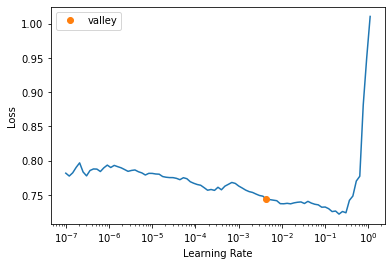

In [112]:
learn.lr_find()

In [113]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(4, 3)
    (2): Embedding(3, 3)
    (3): Embedding(5, 4)
    (4): Embedding(6, 4)
    (5): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=29, out_features=600, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=600, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [114]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.574104,0.561616,0.695458,01:10


In [115]:
preds, y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds,y)
print('The accuracy is {0}%.'.format(acc))

The accuracy is 0.6954584121704102%.


In [116]:
learn.show_results()

,roof,era,home,down,qtr,game_half,score_diff,wp,vegas_wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type,play_type_pred
0,4.0,3.0,1.0,3.0,2.0,1.0,0.511998,0.307173,-0.541760,0.874965,-0.483554,-0.599946,-2.073066,0.592379,0.0,0.0
1,4.0,1.0,1.0,3.0,1.0,1.0,0.140937,0.214085,0.071827,-0.145937,-0.974223,0.330631,0.588323,0.592379,0.0,0.0
2,4.0,3.0,2.0,1.0,4.0,2.0,0.975824,1.384621,1.162877,0.364514,1.438234,-0.561095,-0.742371,-2.286917,1.0,1.0
3,4.0,1.0,2.0,2.0,3.0,2.0,-0.137358,-0.199980,0.023203,0.364514,0.538674,1.005900,0.588323,0.592379,0.0,0.0
4,4.0,2.0,1.0,2.0,4.0,2.0,1.068589,1.598289,1.456258,0.619739,1.274678,-1.197514,0.588323,-0.847269,1.0,1.0
5,4.0,1.0,1.0,1.0,3.0,2.0,1.439650,1.546818,1.404444,0.364514,-1.137780,0.328781,0.588323,0.592379,1.0,1.0
6,4.0,3.0,2.0,1.0,4.0,2.0,-1.436071,-1.521966,-1.466518,-1.932515,-2.078229,-0.403841,0.588323,0.592379,1.0,1.0
7,4.0,1.0,1.0,2.0,4.0,2.0,0.140937,0.755735,0.869596,-0.145937,-1.505782,-1.378819,-0.742371,-0.847269,0.0,1.0
8,2.0,3.0,1.0,2.0,2.0,1.0,-0.508419,-0.603858,0.743331,-0.401162,-0.115552,-0.527794,0.588323,0.592379,0.0,0.0


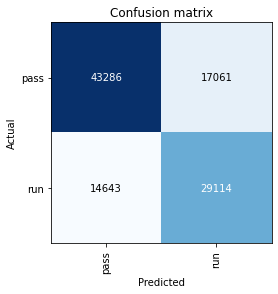

In [117]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [118]:
from sklearn.metrics import roc_curve, auc
probs = (preds[:,1])
# compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs)

# Compute ROC area
roc_auc = auc(fpr,tpr)
print(f'ROC area is {roc_auc}')

ROC area is 0.7677456570339043


In [119]:
print(preds)
print(probs)

tensor([[0.3676, 0.6324],
        [0.4612, 0.5388],
        [0.6113, 0.3887],
        ...,
        [0.7876, 0.2124],
        [0.7920, 0.2080],
        [0.6082, 0.3918]])
tensor([0.6324, 0.5388, 0.3887,  ..., 0.2124, 0.2080, 0.3918])


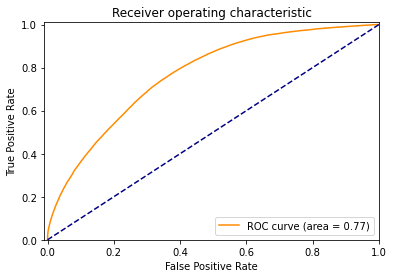

In [120]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


In [121]:
test_df = df.copy()
test_df.drop(['play_type'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(dl=dl)

In [122]:
df['xp'] = preds[0][:,0]

In [123]:

df['play_type_class'] = np.select([df['play_type'] == 'pass', df['play_type'] == 'run'],[1,0], default=0)

df['bin_pred_prob'] = round(df['xp'] / 0.05) * 0.05

df['situation'] = np.select([((df.down == 1) & (df.ydstogo == 10)),
                             (df.down == 2),
                             (df.down == 3)],
                            ['1st & 10', '2nd down', '3rd down'], default = 'Other')
df_xp=(df.groupby(['situation', 'bin_pred_prob']).agg({'play_type_class':[('n_plays','count'),('n_complete', 'sum')]})
 .droplevel(level=0, axis=1)
 .reset_index()
 .assign(bin_actual_prob= lambda x: x.n_complete / x.n_plays)
)
df_xp

,situation,bin_pred_prob,n_plays,n_complete,bin_actual_prob
0,1st & 10,0.00,510,11,0.021569
1,1st & 10,0.05,2750,92,0.033455
2,1st & 10,0.10,1898,165,0.086934
3,1st & 10,0.15,1851,243,0.131280
4,1st & 10,0.20,2317,433,0.186880
...,...,...,...,...,...
78,Other,0.80,1015,861,0.848276
79,Other,0.85,1341,1163,0.867263
80,Other,0.90,2267,2067,0.911778
81,Other,0.95,1161,1120,0.964686


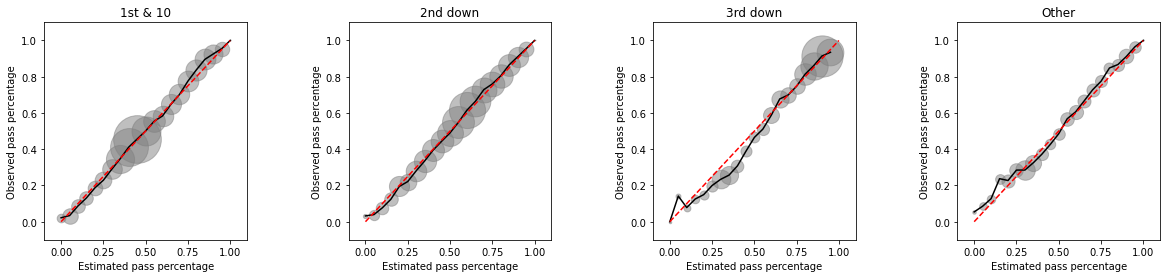

In [124]:
# from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = (0,1)
        low_y, high_y = (0,1)
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


fig, ax = subplots(1,4, figsize=(20,4))
fig.subplots_adjust(wspace=0.5)
for idx, situation in enumerate(df_xp.situation.unique()):
    for row_idx, row in df_xp[df_xp.situation == situation].iterrows():
        ax[idx].scatter(x=row.bin_pred_prob, y=row.bin_actual_prob, s=2**np.log(row.n_plays), alpha=0.5,color='grey')
    ax[idx].plot('bin_pred_prob', 'bin_actual_prob', data=df_xp[df_xp.situation == situation], color='k')
    add_identity(ax[idx], color='r', ls='--')
    ax[idx].set_title(situation)
    ax[idx].set_xlim([-0.1,1.1])
    ax[idx].set_ylim([-0.1,1.1])
    ax[idx].set_xlabel('Estimated pass percentage')
    ax[idx].set_ylabel('Observed pass percentage')
    

plt.show()

In [125]:
# Calculate error between expected and observed

wm = lambda x: np.average(x, weights=df_xp.loc[x.index, "n_plays"])

df_xp['cal_diff'] = abs(df_xp.bin_pred_prob - df_xp.bin_actual_prob)
xp_cv_cal_error = df_xp.groupby('situation').agg(n_complete=('n_complete','sum'),weighted_cal_error=('cal_diff',wm))
round(np.average(xp_cv_cal_error.weighted_cal_error, weights=xp_cv_cal_error.n_complete),4)


0.0148

In [73]:
# https://www.opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/#expected-pass-model-calibration-results
# model calibration of NFLverse  Expected Pass Model is 0.008

In [28]:
# explore why 3rd down is a problem for the model
xp_range = (df.xp > .25)&(df.xp < .75)
on_3rd_down = (df.down == 3)

df[xp_range & on_3rd_down]

,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,xp,play_type_class,bin_pred_prob,situation
57,pass,outdoors,2.0,-3.0,1,3.0,2.0,66.0,Half1,2.0,460.0,3.0,2.0,0.510377,0.657448,1,0.65,3rd down
119,run,outdoors,2.0,7.0,0,3.0,1.0,41.0,Half2,3.0,1059.0,2.0,3.0,0.804834,0.389273,0,0.40,3rd down
154,run,outdoors,2.0,14.0,0,3.0,12.0,82.0,Half2,4.0,339.0,2.0,2.0,0.987814,0.560647,0,0.55,3rd down
241,pass,outdoors,2.0,14.0,0,3.0,8.0,91.0,Half1,2.0,342.0,2.0,1.0,0.836260,0.720018,1,0.70,3rd down
257,run,outdoors,2.0,-17.0,1,3.0,20.0,78.0,Half1,2.0,54.0,0.0,1.0,0.073967,0.646243,0,0.65,3rd down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794393,pass,outdoors,4.0,-8.0,1,3.0,2.0,48.0,Half2,3.0,1320.0,3.0,3.0,0.255741,0.576788,1,0.60,3rd down
794448,run,outdoors,4.0,0.0,1,3.0,1.0,55.0,Half2,4.0,68.0,3.0,2.0,0.684787,0.345136,0,0.35,3rd down
794470,pass,outdoors,4.0,0.0,1,3.0,1.0,49.0,Overtime,5.0,424.0,2.0,2.0,0.592451,0.390673,1,0.40,3rd down
794473,pass,outdoors,4.0,0.0,1,3.0,1.0,13.0,Overtime,5.0,317.0,2.0,2.0,0.891303,0.288673,1,0.30,3rd down


In [29]:
# test LeaveOneGroupOut (season) validation 
# from sklearn.model_selection import LeaveOneGroupOut, train_test_split

# train, test  = train_test_split(df, test_size=0.2)

# val_pct, tst_preds = L(), L()
# logo = LeaveOneGroupOut()
# logo.get_n_splits(groups=train.season)

# for train_idx, valid_idx in logo.split(train.index,  train['play_type'], groups=train.season): # right here
#     splits = (L(list(train_idx)), L(list(valid_idx)))
#     procs = [Categorify, Normalize, FillMissing]
#     to = TabularPandas(train, procs, cat_names, cont_names, y_names='play_type',
#                        splits=splits)
#     dls = to.dataloaders(bs=512)
#     learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
#     learn.fit(3, 1e-2)
#     test_dl = learn.dls.test_dl(test)
#     with learn.no_bar():
#         val_pct.append(learn.validate()[-1])
#         tst_preds.append(learn.get_preds(dl=test_dl))
# for i, (pred, truth) in enumerate(tst_preds):
#     print(f'Fold {i+1}: {accuracy(pred, truth)}')
# sum_preds = []
# for i, (pred, truth) in enumerate(tst_preds):
#     sum_preds.append(pred.numpy())
# avg_preds = np.sum(sum_preds, axis=0) / 16
# print(f'Average Accuracy: {accuracy(tensor(avg_preds), tst_preds[0][1])}')